In [63]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

print("You can train it on CPU")

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!
You can train it on CPU


# Intall packages

In [ ]:
!pip install mediapipe tensorflow transformers

# Import Packages

In [3]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import json
import glob
from typing import List, Optional, Tuple, Union, Mapping
from dataclasses import dataclass

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Masking, Reshape, Conv1D, MaxPooling1D, MaxPool1D, GlobalMaxPool1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

In [5]:
#Define workdir
workdir = "/content/drive/MyDrive/Sign_lang"
os.chdir(workdir)

In [ ]:
!ls

In [7]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.17.0


# Mediapipe video to matrix

In [8]:
mp_holistic = mp.solutions.holistic
mp_draw = mp.solutions.drawing_styles

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def preprocess(array):
  mean = np.mean(array)
  std = np.std(array)
  return (array-mean)/std

In [9]:
# Spécifications de dessin
@dataclass
class DrawingSpec:
    color: tuple
    thickness: int
    circle_radius: int

WHITE_COLOR = (255, 255, 255)
RED_COLOR =  WHITE_COLOR #(0, 0, 255)
_BGR_CHANNELS = 3

def draw_face_landmarks(
    image: np.ndarray,
    landmarks: np.ndarray,  # Remplacé de `landmark_list`
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Optional[
        Union[DrawingSpec, Mapping[int, DrawingSpec]]
    ] = DrawingSpec(color=RED_COLOR, thickness=2, circle_radius=5),
    connection_drawing_spec: Union[
        DrawingSpec, Mapping[Tuple[int, int], DrawingSpec]
    ] = DrawingSpec(color=RED_COLOR, thickness=1, circle_radius=5),
    is_drawing_landmarks: bool = True,
):
    """Draws the face landmarks and the connections on the image.

    Args:
        image: A three-channel BGR image represented as numpy ndarray.
        landmarks: A numpy array of face landmarks with shape (468, 3).
        connections: A list of landmark index tuples that specifies how landmarks to
                     be connected in the drawing.
        landmark_drawing_spec: Either a DrawingSpec object or a mapping from face
                               landmarks to the DrawingSpecs that specifies the landmarks' drawing
                               settings such as color, line thickness, and circle radius.
        connection_drawing_spec: Either a DrawingSpec object or a mapping from face
                                  connections to the DrawingSpecs that specifies the connections' drawing
                                  settings such as color and line thickness.
        is_drawing_landmarks: Whether to draw landmarks. If set false, skip drawing
                              landmarks, only contours will be drawn.

    Raises:
        ValueError: If the input image is not three-channel BGR.
    """
    if image.shape[2] != _BGR_CHANNELS:
        raise ValueError('Input image must contain three channel BGR data.')

    image_rows, image_cols, _ = image.shape
    idx_to_coordinates = {}

    for idx, (x, y, z) in enumerate(landmarks):
        # Convert normalized coordinates to pixel coordinates
        landmark_px = (int(x * image_cols), int(y * image_rows))  # Here z is ignored for 2D display
        idx_to_coordinates[idx] = landmark_px

    if connections:
        num_landmarks = len(landmarks)
        # Draw the connections if the start and end landmarks are both visible
        for connection in connections:
            start_idx, end_idx = connection
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                 f'from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                drawing_spec = connection_drawing_spec if not isinstance(
                    connection_drawing_spec, Mapping) else connection_drawing_spec.get(connection, DrawingSpec(color=RED_COLOR, thickness=1))
                cv2.line(image, idx_to_coordinates[start_idx], idx_to_coordinates[end_idx],
                         drawing_spec.color, drawing_spec.thickness)

    if is_drawing_landmarks and landmark_drawing_spec:
        for idx, landmark_px in idx_to_coordinates.items():
            drawing_spec = landmark_drawing_spec if not isinstance(
                landmark_drawing_spec, Mapping) else landmark_drawing_spec.get(idx, DrawingSpec(color=RED_COLOR, thickness=2, circle_radius=5))
            # Draw the landmark points
            circle_border_radius = max(drawing_spec.circle_radius + 1,
                                       int(drawing_spec.circle_radius * 1.2))
            '''cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR,
                       drawing_spec.thickness)
            cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                       drawing_spec.color, drawing_spec.thickness)'''


In [10]:
#mp_holistic.FACEMESH_CONTOURS
# Couleurs personnalisées pour les mains
left_hand_spec = DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=5)  # Vert pour la main gauche
right_hand_spec = DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=5)  # Bleu pour la main droite

def display_landmarks(frame, face, pose, lh, rh):
    # Dessiner les landmarks du visage
    draw_face_landmarks(image=frame, landmarks=face, connections=mp_holistic.FACEMESH_CONTOURS)

    # Dessiner les landmarks du corps
    draw_face_landmarks(image=frame, landmarks=pose, connections=mp_holistic.POSE_CONNECTIONS)

    # Dessiner les landmarks de la main gauche (avec couleur verte)
    draw_face_landmarks(image=frame, landmarks=lh, connections=mp_holistic.HAND_CONNECTIONS,
                        landmark_drawing_spec=left_hand_spec,
                        connection_drawing_spec=left_hand_spec)

    # Dessiner les landmarks de la main droite (avec couleur bleue)
    draw_face_landmarks(image=frame, landmarks=rh, connections=mp_holistic.HAND_CONNECTIONS,
                        landmark_drawing_spec=right_hand_spec,
                        connection_drawing_spec=right_hand_spec)

    # Afficher le résultat
    # cv2_imshow(frame)


  #cv2_imshow(frame)

In [11]:


holistic=mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Exemple de fonction pour traiter une vidéo
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all = []

    if not cap.isOpened():
        print("Error: Could not open video.")
    else:

        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Frames per second (FPS): {fps}")
        print(f"Total number of frames: {frame_count}")

        frame_index = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                # Fin de vidéo ou erreur
                print("No more frames or error occurred.")
                break

            if frame is None or frame.size == 0:
                # Frame corrompue
                print("Error: Frame is invalid or empty. Trying to continue...")
                continue


            # Processer l'image avec MediaPipe Holistic
            frame, results = mediapipe_detection(frame, holistic)

            #draw_styled_landmarks(frame, results)
            pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 3))
            face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468, 3))
            lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
            rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))


            out = np.concatenate([face, pose, lh, rh])
            all.append(np.array(out))



            frame_index += 1
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
                break
        cap.release()

        padding = 60
        all = all[:padding] if len(all) > padding else all+list(np.zeros((padding-len(all), all[0].shape[0], all[0].shape[1] )))
        all= np.array(all)

        #Preprocessing
        #all = preprocess(all)

        return all



# Display the landmarks

In [12]:
#Test
video_path = "video_data/train/book/07068.mp4"
out = process_video(video_path)
out.shape

Frames per second (FPS): 25.0
Total number of frames: 58


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


No more frames or error occurred.


(60, 543, 3)

In [13]:
x = out[:1, :, 0]
y = out[:1,:, 1]
z = out[:1, :, 2]
print(x.shape, y.shape,z.shape)

(1, 543) (1, 543) (1, 543)


 ## Draw landmarks

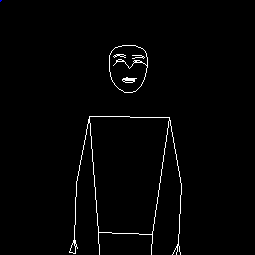

In [14]:
#make Black background

height = 255
width = 255
for i in range(1):
  img = np.zeros((height, width, 3), dtype=np.uint8)
  matrix = out[i]
  face = matrix[:468]
  pose = matrix[468: 501]
  lh = matrix[501: 522]
  rh = matrix[522: ]
  display_landmarks(img, face, pose, lh, rh)
  cv2_imshow(img)


# Make Landmarks dataset


*   Pour chaque video, nous avons une matrice de (100, 543, 3); nous allons creer une dataset divisé en train, test, val

*   Chaque tranche de données(train, test, val) contient des dossiers portant les noms des labels.
*   Nous allons sauvegarder ces données dans les folders en format .npy qui sera utilisé plus tard par les models.



## Create folders and moove videos

In [16]:
with open(os.path.join(workdir, "word_classes.txt")) as f:
  liste = f.readlines()
liste = [i.split("\t")[-1].split("\n")[0] for i in liste]
liste = [i for i in liste if i!= '']
print(f"We have {len(liste)} differents words")

We have 2000 differents words


In [17]:
# We'll use just the 5 st words for test purposes
classes_list = liste[:5]

In [18]:
with open("WLASL_v0.3.json", "r") as f:
  json_data = json.load(f)
print(json_data[0:1])

[{'gloss': 'book', 'instances': [{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'http://aslbricks.org/New/ASL-Videos/book.mp4', 'variation_id': 0, 'video_id': '69241'}, {'bbox': [190, 25, 489, 370], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 1, 'signer_id': 90, 'source': 'aslsignbank', 'split': 'train', 'url': 'https://aslsignbank.haskins.yale.edu/dictionary/protected_media/glossvideo/ASL/BO/BOOK-418.mp4', 'variation_id': 0, 'video_id': '65225'}, {'bbox': [262, 1, 652, 480], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 2, 'signer_id': 110, 'source': 'valencia-asl', 'split': 'train', 'url': 'https://www.youtube.com/watch?v=0UsjUE-TXns', 'variation_id': 0, 'video_id': '68011'}, {'bbox': [123, 19, 516, 358], 'fps': 25, 'frame_end': 60, 'frame_start': 1, 'instance_id': 3, 'signer_id': 113, 'source': 'lillybauer', 'split': 'train', 'url': 'https:/

In [19]:
#Define directories
sign_video_data_dir ="video_data"
train_dir =os.path.join(sign_video_data_dir, "train")
val_dir =os.path.join(sign_video_data_dir, "val")
test_dir = os.path.join(sign_video_data_dir, "test")

if not os.path.exists(sign_video_data_dir):
  os.mkdir(sign_video_data_dir)
  os.mkdir(train_dir)
  os.mkdir(val_dir)
  os.mkdir(test_dir)

In [20]:
!cd video_data/ && ls

test  train  val


In [21]:
for data in json_data[:10]:
  for instances in data["instances"]:
    #print(instances['split'], instances['url'], data['gloss'])# instances['video_id'] )#['fps'])
    #print(path)
    path = os.path.join(sign_video_data_dir, f"{instances['split']}/{data['gloss']}")
    print(instances)
    break

  break

{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'http://aslbricks.org/New/ASL-Videos/book.mp4', 'variation_id': 0, 'video_id': '69241'}


In [52]:
# Split Video
import shutil
for data in json_data:
  for instances in data["instances"]:
    #print(instances['split'], instances['url'], data['gloss'])# instances['video_id'] )#['fps'])
    path = os.path.join(sign_video_data_dir, f"{instances['split']}/{data['gloss']}")
    video_path = f"/content/drive/MyDrive/Tensorflow dev/real_time_sign_language/wasl_data/wlasl-complete/videos/{instances['video_id']}.mp4"
    try:
      shutil.move(video_path, os.path.join(path, f"{instances['video_id']}.mp4"))
    except:
      pass
      #print(video_path, os.path.join(path, f"{instances['video_id']}.mp4"))


#Videos to Array

In [68]:
X_train, y_train = [], []
X_test, y_test = [], []
X_val, y_val = [], []

In [69]:
def process_videos(video_paths, label):
    X, y = [], []
    for val, video_path in enumerate(video_paths):
        try:
            X.append(process_video(video_path))
            y.append(label)
        except Exception as e:
            print(e)
    return X, y

print(train_dir)



for classes in classes_list:
    train_videos = glob.glob(os.path.join(train_dir, classes, "*.mp4"))[:35]
    test_videos = glob.glob(os.path.join(test_dir, classes, "*.mp4"))
    val_videos = glob.glob(os.path.join(val_dir, classes, "*.mp4"))

    X_t, y_t = process_videos(train_videos, classes)
    #X_t = np.array([video_maker_dataset(i) for i in X_t])
    X_train.extend(X_t)
    y_train.extend(y_t)

    X_t, y_t = process_videos(test_videos, classes)
    #X_t = np.array([video_maker_dataset(i) for i in X_t])
    X_test.extend(X_t)
    y_test.extend(y_t)

    X_t, y_t = process_videos(val_videos, classes)
    #X_t = np.array([video_maker_dataset(i) for i in X_t])
    X_val.extend(X_t)
    y_val.extend(y_t)



video_data/train


  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



Frames per second (FPS): 25.0
Total number of frames: 58
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 31
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 73
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 18
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 28
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 33
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 69
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 90
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 99
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 79
No more frames or error occurred.
Frames per second (FPS): 25.0
Total number of frames: 93
No more frames or error occurred.

In [70]:
holistic.close()

In [71]:
#Nombre de videos par classe
count_dict = {}

# Compter les occurrences de chaque élément
for item in y_train:
    if item in list(count_dict):
        count_dict[item] += 1
    else:
        count_dict[item] = 1

# Filtrer et afficher les éléments qui se répètent
repeated_elements = {key: value for key, value in count_dict.items() if value > 1}
print("Nombre de classes:", len(repeated_elements))
print("Nbre de videos par classes", repeated_elements)

Nombre de classes: 5
Nbre de videos par classes {'book': 35, 'drink': 30, 'computer': 29, 'before': 18, 'chair': 19}


## Encode Label

In [72]:
def encoder_label(label):
  encode = LabelEncoder()
  one_hot = OneHotEncoder(sparse=False)
  new_label= encode.fit_transform(label)
  outlabel= one_hot.fit_transform(new_label.reshape(len(new_label), 1))
  return outlabel


In [73]:
y_train = encoder_label(y_train)
y_test = encoder_label(y_test)
y_val = encoder_label(y_val)

  warnings.warn(

  warnings.warn(

  warnings.warn(



In [74]:
y_train[0]

array([0., 1., 0., 0., 0.])

In [75]:
#Test
holistic=mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
video_path = "video_data/train/before/05734.mp4"
out = process_video(video_path)
print(f"out shape: {out.shape}")

holistic.close()

Frames per second (FPS): 25.0
Total number of frames: 69


  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



No more frames or error occurred.
out shape: (60, 543, 3)


## Save data

In [76]:
# Sauvegarde des données
np.save('X_train.npy', X_train)  # Shape: (112, 100, 543, 3)
np.save('X_test.npy', X_test)    # Shape: (20, 100, 543, 3)
np.save('X_val.npy', X_val)      # Shape: (25, 100, 543, 3)
np.save('y_train.npy', y_train)  # Shape: (112, 5)
np.save('y_test.npy', y_test)    # Shape: (20, 5)
np.save('y_val.npy', y_val)      # Shape: (25, 5)


# Load the Data

In [23]:
# Load Data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
X_val = np.load('X_val.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_val = np.load('y_val.npy')


In [24]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(131, 60, 543, 3) (131, 5) (20, 60, 543, 3) (20, 5) (25, 60, 543, 3) (25, 5)


# Model

## Functions

In [51]:
def history_curve(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  plt.figure(figsize=(14, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, "ro-", label="train accuracy")
  plt.plot(epochs, loss, "bo-", label="train loss")
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy curve")
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)

  plt.plot(epochs, val_acc, "ro-", label="val accuracy")
  plt.plot(epochs, val_loss, "bo-", label="val loss")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.title("loss curve")
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

## . CNN - LSTM

In [26]:
X_train[0].shape

(60, 543, 3)

### A-) First CNN-LSTM architecture

In [27]:
# then started writing our two model
model=Sequential(name="CNNLSTM")
model.add(TimeDistributed(Conv1D(64,kernel_size=3,padding="same",activation="relu"),input_shape=X_train.shape[1:]))
model.add(TimeDistributed(MaxPool1D()))
model.add(TimeDistributed(Conv1D(96,kernel_size=3,padding="same",activation="relu")))
model.add(TimeDistributed(MaxPool1D()))
model.add(TimeDistributed(Conv1D(128,kernel_size=3,padding="same",activation="relu")))
model.add(TimeDistributed(GlobalMaxPool1D()))
model.add(LSTM(90,dropout=0.4,return_sequences=True))
model.add(LSTM(45,dropout=0.4))
model.add(Dense(100,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(50,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(len(classes_list),activation="softmax"))
model.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CNNLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 60, 543, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 60, 271, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 60, 271, 96)         │          18,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 60, 135, 96)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 60, 135, 128)        │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 60, 90)              │          78,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 45)                  │          24,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │           4,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,985 (664.00 KB)

 Trainable params: 169,685 (662.83 KB)

 Non-trainable params: 300 (1.17 KB)

In [28]:
# Entraînement du modèle
history = model.fit(X_train, y_train, batch_size=16, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 845ms/step - accuracy: 0.2196 - loss: 2.5901 - val_accuracy: 0.1600 - val_loss: 1.6064
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.2052 - loss: 2.4888 - val_accuracy: 0.1600 - val_loss: 1.6178
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.2024 - loss: 2.3708 - val_accuracy: 0.1600 - val_loss: 1.6054
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.2305 - loss: 2.2511 - val_accuracy: 0.1600 - val_loss: 1.6400
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.1472 - loss: 2.4536 - val_accuracy: 0.1600 - val_loss: 1.6344
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step - accuracy: 0.2151 - loss: 2.2486 - val_accuracy: 0.2400 - val_loss: 1.6431
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.2197 - loss: 2.2231 - val_accuracy: 0.2000 - val_loss: 1.6477
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - accuracy: 0.2112 - loss: 2.3883 - val_accuracy: 0.2400 - 

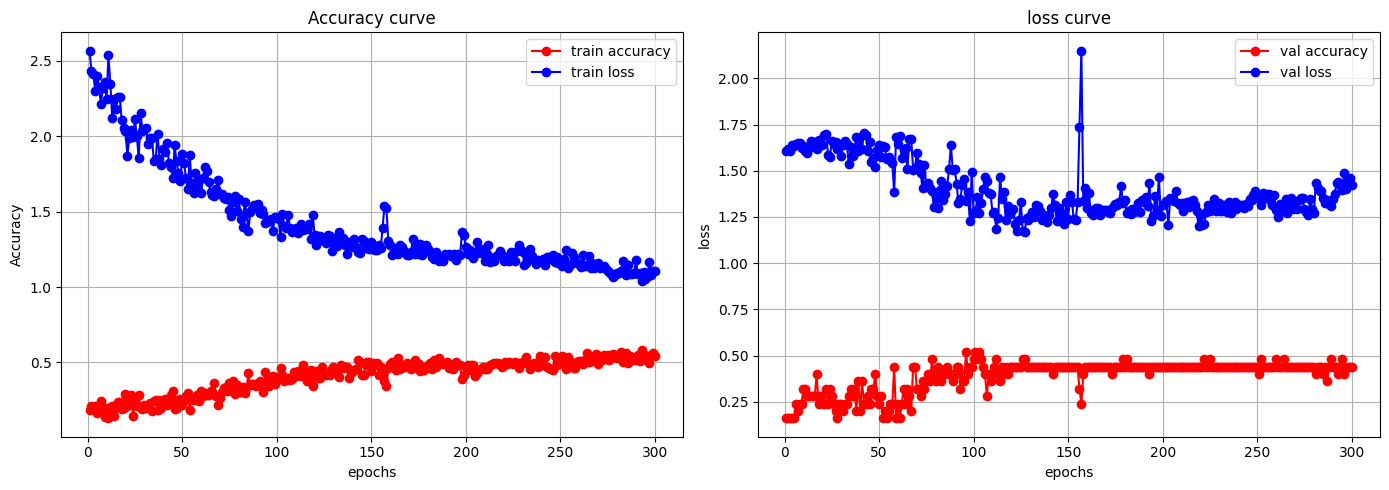

In [29]:
history_curve(history)

### B-) Second CNN-LSTM architecture:

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

# Dimensions des données d'entrée (60 frames, 64x64 images en niveaux de gris)
input_shape = X_train.shape[1:]
num_classes = len(classes_list)  # Le nombre de classes dans votre ensemble de données

# Création du modèle avec l'API Sequential
model_b = Sequential(name="CNN_LSTM_Model_b")

# Ajout des couches TimeDistributed avec Conv2D, MaxPooling et BatchNormalization
model_b.add(layers.TimeDistributed(layers.Conv1D(32, kernel_size=3, activation='relu'), input_shape=X_train.shape[1:]))
#model_b.add(TimeDistributed(Conv1D(64,kernel_size=3,padding="same",activation="relu"),input_shape=X_train.shape[1:]))
model_b.add(layers.TimeDistributed(layers.MaxPooling1D()))
model_b.add(layers.TimeDistributed(layers.BatchNormalization()))

model_b.add(layers.TimeDistributed(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')))
model_b.add(layers.TimeDistributed(layers.MaxPooling1D()))
model_b.add(layers.TimeDistributed(layers.BatchNormalization()))

model_b.add(layers.TimeDistributed(layers.Conv1D(128,  kernel_size=3, activation='relu', padding='same')))
model_b.add(layers.TimeDistributed(layers.MaxPooling1D()))
model_b.add(layers.TimeDistributed(layers.BatchNormalization()))

model_b.add(layers.TimeDistributed(layers.Flatten()))

# Ajout de la couche LSTM
model_b.add(layers.LSTM(128, return_sequences=False))
model_b.add(layers.Dropout(0.5))

#Dense
model.add(Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# Couche de sortie
model_b.add(layers.Dense(num_classes, activation='softmax'))

# Compilation du modèle
model_b.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model_b.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "CNN_LSTM_Model_b"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_26                  │ (None, 60, 541, 32)         │             320 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 60, 270, 32)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 60, 270, 32)         │             128 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 60, 270, 64)         │           6,208 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 60, 135, 64)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 60, 135, 64)         │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 60, 135, 128)        │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 60, 67, 128)         │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 60, 67, 128)         │             512 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_35                  │ (None, 60, 8576)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │       4,456,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,489,733 (17.13 MB)

 Trainable params: 4,489,285 (17.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [43]:
history_b = model_b.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=470,
                    batch_size=16)

Epoch 1/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.2359 - loss: 1.7629 - val_accuracy: 0.2000 - val_loss: 1.6358
Epoch 2/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4414 - loss: 1.4033 - val_accuracy: 0.5200 - val_loss: 1.3590
Epoch 3/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.3888 - loss: 1.4699 - val_accuracy: 0.4400 - val_loss: 1.3803
Epoch 4/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4547 - loss: 1.4155 - val_accuracy: 0.4000 - val_loss: 1.3839
Epoch 5/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.4129 - loss: 1.3847 - val_accuracy: 0.4400 - val_loss: 1.4912
Epoch 6/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 342ms/step - accuracy: 0.5042 - loss: 1.2834 - val_accuracy: 0.5600 - val_loss: 1.3914
Epoch 7/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.4780 - loss: 1.2466 - val_accuracy: 0.6000 - val_loss: 1.2276
Epoch 8/470
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.4747 - loss: 1.2140 - val_accuracy: 0.6000 - val

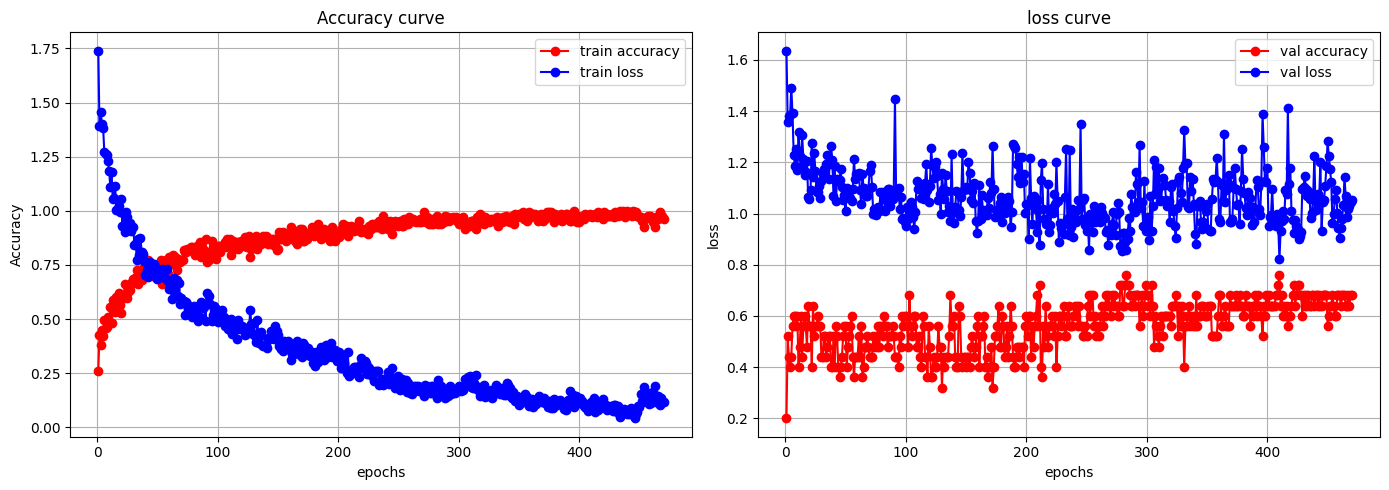

In [52]:
history_curve(history_b)

# Prediction

In [39]:
print(classes_list[np.argmax(model_b.predict(X_test[0:1]))])
print(classes_list[np.argmax(y_test[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
drink
drink


In [53]:
print(classes_list[np.argmax(model_b.predict(X_test[0:1]))])
print(classes_list[np.argmax(y_test[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
drink
drink


In [ ]:
model_b.evaluate(X_test, y_test)

## Prediction Pipeline

In [58]:
def pipeline(video_path):
  out= process_video(video_path)
  predict = model_b.predict(out.reshape(1, out.shape[0], out.shape[1], out.shape[-1]))
  predict = classes_list[np.argmax(predict)]
  return predict

In [56]:
classes_list

['book', 'drink', 'computer', 'before', 'chair']

In [ ]:
#Test
holistic=mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
video_path = "video_data/val/computer/12335.mp4"
y_pred = pipeline(video_path)
print(f"the model predict {y_pred}, the real class is {video_path.split('/')[-2]}")
holistic.close()

## Save model

In [60]:
# Save the trained model
model_b.save('sign_model.keras')


In [62]:
model_b = tf.keras.models.load_model("sign_model.keras")
model_b.predict(X_test[0:1])

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 71 variables whereas the saved optimizer has 63 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0.        , 0.05592752, 0.        , 0.01519276, 0.        ,
        0.        , 0.10923982, 0.        , 0.02899458, 0.        ,
        0.0737476 , 0.        , 0.01809211, 0.        , 0.0288182 ,
        0.        , 0.01144228, 0.        , 0.        , 0.01220349,
        0.        , 0.00291862, 0.00774125, 0.09394211, 0.        ,
        0.        , 0.        , 0.01291607, 0.        , 0.        ,
        0.        , 0.07211287, 0.        , 0.        , 0.        ,
        0.02120127, 0.        , 0.        , 0.00114618, 0.00114218,
        0.01773597, 0.00779424, 0.        , 0.0717412 , 0.02407682,
        0.06386174, 0.05086319, 0.01725821, 0.01107975, 0.        ,
        0.        , 0.        , 0.01977541, 0.02917122, 0.        ,
        0.01195592, 0.        , 0.08556645, 0.04832245, 0.02435196,
        0.        , 0.        , 0.        , 0.        ]], dtype=float32)